## HOMEWORK 4
## 1) Does basic house information reflect house's description?

In this part of the homework our task is to perform a clustering analysis of house announcements in Rome from Immobiliare.it. We will create two datasets by retrieving data from websites. Then, we will
implement two clustering methods and compare the results.

**Python Libraries and Settings:**

In [148]:
import time
import threading
import requests
from bs4 import BeautifulSoup
import re
import csv
import pandas as pd
import numpy as np

# for the clustering part:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# set figure size 
plt.rcParams["figure.figsize"] = [16,9]

# for hiding warnings
import warnings
warnings.filterwarnings('ignore')

# our external module:
import collect_data
import functions

### **Scraping data**

As the first step, we are collecting the list of interesting urls, starting from the website:
https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1.

+ We are using the time.sleep function to prevent the websie blocking.
+ The implementation of "thread_find_links" function is located in the external file **collect_data.py**

In [ ]:
link_threads = []
for nr_page in range(1, 100):
    t = threading.Thread(target=collect_data.thread_find_links, args=("nr_page",))
    t.start()
    time.sleep(1)

+ We are saving collected links into **links.txt** file

In [64]:
print("The number of collected links: {}".format(len(link_threads)))

The number of collected links: 25974


In [ ]:
with open("links.txt", "w") as link_file:
    for url_ in link_threads:
        link_file.write(url_)

In [8]:
# Load data from link.txt 
with open("links.txt", "r") as link_file:
    link_threads = link_file.readlines()

+ We are iterating through collected links to retrieve and save data about flats. 
+ For this, we defined the fuction **threadExtract**. 
+ We applied the parallel programming by generating threads for each url. 

In [27]:
def threadExtract(url):
    """
    This function gets html content and scraps the interesting data
    Input: String: "url" 
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    # use defined function for retrieving data from websites
    scrapped_data = collect_data.scrap_data(soup)
    if scrapped_data != None:
        datawriter.writerow(scrapped_data)

+ The collected data are saved in **flat_data.txt** file.

In [33]:
# data_file = open("flat_data.txt", "w", encoding='utf-8')
headers = ["price", "locali", "superficie", "bagni", "piano", "description"]
datawriter = csv.writer(data_file)
datawriter.writerow(headers)

49

In [ ]:
failed_links = []

def create_threads(from_, to_):
    for link_ in link_threads[from_ : to_]:
        # try collect data from the website
        try:
            threading.Thread(threadExtract(link_[:-1])).start() #-1 because we have "\n" in the end of a link
            time.sleep(3) #for non-blocking
        except Exception as e:
            print(e)
            failed_links.append(link_)

In [ ]:
# Run threads for previously collected links: 
for rep in range(0, 20000, 100):
    create_threads(from_= rep, to_ = rep+100)

data_file.close()

### Datasets

We are reading the **flat_data.txt** file content as dataframe.
Then, we are splitting the collected data into two separated datasets:
+ **Information dataset** : [price, locali, superficie, bagni, piano]
+ **Description dataset** : [TFIDF matrix for descriptions]

In [3]:
data_frame = pd.read_csv("flat_data.txt")

In [4]:
data_frame.head()

,price,locali,superficie,bagni,piano,description
0,1260000,5,225,2,4,In stabile signorile in Via Appia Nuov...
1,245000,2,80,1,2,Rif: G118 - APPIA NUOVA STATUARIO Via ...
2,319000,3,114,1,1,proponiamo in vendiata ampio e luminos...
3,630000,4,153,2,5,Rif: 20141 - Appartamento composto da ...
4,157000,3,68,1,1,Proponiamo la vendita di un trilocale ...


In [4]:
print("We managed to collect data about {} announcements".format(len(data_frame)))

We managed to collect data about 10544 announcements


**Information dataset**

In [5]:
inf_dataset = data_frame[["price", "locali", "superficie", "bagni", "piano"]]
inf_dataset.head()

,price,locali,superficie,bagni,piano
0,1260000,5,225,2,4
1,245000,2,80,1,2
2,319000,3,114,1,1
3,630000,4,153,2,5
4,157000,3,68,1,1


**Description Dataset**

In order to create the TFIDF matrix (Description Dataset), we created the separated Jupyter Notebook **TFIDF_matrix**. After running the code there, the following files were generated:
+ vocabulary.txt
+ inverted_indx.txt
+ tfid.csv

We are reading **vocabulary.txt** and **tfid.csv** using pre-defined **read_vocabulary** and **read_tfid** functions, which are located in our **functions** module.

In [130]:
vocabulary = functions.read_vocabulary(file = 'vocabulary.txt')

In [150]:
tfid = functions.read_tfid(file = 'tfid.csv')

The next step is creating the **description_matrix**, where all rows correspond to announcements and columns to word_ids from descriptions.

We are putting data about **tfidf scores** into DataFrame. 

Words which do not exist in all annoucements (missing values) are replaced from NaN into 0.

In [3]:
dict_df = pd.DataFrame(columns=[i for i in range(len(vocabulary))])
# filling dataframe row by row :
for i in range(len(tfid)):
    dict_df = dict_df.append(tfid[i], ignore_index=True)

# change NaN values to 0.
dict_df = dict_df.fillna(0)

# name for the index column
dict_df.index.name = "Ann_index"    #TODO: what with index column ?
#description_data_frame.drop(columns = ["Ann_index"])
dict_df.head()

Saving **Descriptin Matrix** to the **description_matrix.csv** file.

In [7]:
dict_df.to_csv("description_matrix.csv")

In [8]:
# READING
description_dataset = pd.read_csv("description_matrix.csv")

## Clustering

###  K-means++

This part consists of clustering the house announcements using K-means++ method. 
In order to choose the optimal number of clusters we used the Elbow-Method.

+ We are iterating through a different number of cluster "k"
+ Clusters are saved as an additional column in a dataframe

#### INFORMATION DATASET
1) Perform the Elbow-Method to choose the best number of clusters:

In [41]:
inf_dataset.head()

,price,locali,superficie,bagni,piano
0,1260000,5,225,2,4
1,245000,2,80,1,2
2,319000,3,114,1,1
3,630000,4,153,2,5
4,157000,3,68,1,1


In [44]:
inf_dataset_scores = {}
for k in range(1,20):
    kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(inf_dataset)
    #inf_dataset['clusters'+str(k)] = kmeanModel.labels_ #TODO: consider saving cluster somewhere
    inf_dataset_scores[k] = kmeanModel.inertia_ 

2) Plot results (inf_dataset_scores):

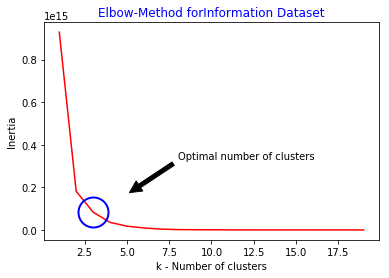

In [104]:
def plot_inertia(dataset_scores, info):
    x = list(dataset_scores.keys())
    y = list(dataset_scores.values())
    fig = plt.figure()
    plt.plot(x,y, color = "red")
    plt.plot(x[2], y[2], 'o', ms=30, mec='b', mfc='none', mew=2)
    plt.annotate('Optimal number of clusters', 
                 xy=(x[2]+2, 2*y[2]), xytext=(x[2]+5, 4*y[2]),
                 arrowprops = dict(facecolor='black', shrink=0.05))
    plt.title("Elbow-Method for" + info, color="blue")
    plt.xlabel("k - Number of clusters")
    plt.ylabel("Inertia")
    plt.show()
    fig.savefig("optimal-clusters-" + info + ".png")
    
plot_inertia(dataset_scores=inf_dataset_scores, info="Information Dataset")

3) Perform clustering for the best number of clusters. In this case for **nr_clusters = 3**

In [99]:
kmeanModel = KMeans(n_clusters=3, max_iter=1000).fit(inf_dataset)
inf_dataset['information_clusters'] = kmeanModel.labels_

In [100]:
inf_dataset.head()

,price,locali,superficie,bagni,piano,information_clusters
0,1260000,5,225,2,4,2
1,245000,2,80,1,2,0
2,319000,3,114,1,1,0
3,630000,4,153,2,5,1
4,157000,3,68,1,1,0


#### DESCRIPTION DATASET
1) Perform the Elbow-Method to choose the best number of clusters:


In [ ]:
description_dataset.head()

In [102]:
description_dataset_scores = {}
for k in range(1,20):
    kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(description_dataset)
    description_dataset_scores[k] = kmeanModel.inertia_

2) Plot results (description_dataset_scores):

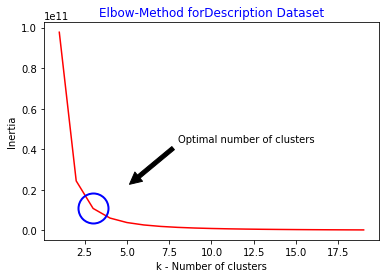

In [105]:
plot_inertia(dataset_scores=description_dataset_scores, info="Description Dataset")

3) Perform clustering for the best number of clusters. In this case, for **nr_clusters = 3**

In [106]:
kmeanModel = KMeans(n_clusters=3, max_iter=1000).fit(description_dataset)
description_dataset['description_clusters'] = kmeanModel.labels_

In [107]:
description_dataset.head() #TODO: check cluster counts

,Ann_index,0,1,2,3,4,5,6,7,8,...,754,755,756,757,758,759,760,761,762,description_clusters
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,-0.0538,0.00000,0.0,0.0,0.00000,1
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.00000,0.0,0.0,0.00000,1
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-0.0538,...,0.0,0.0,0.0,0.0,0.0000,-0.04501,0.0,0.0,0.00000,1
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.04501,-0.0538,...,0.0,0.0,0.0,0.0,0.0000,0.00000,0.0,0.0,0.00000,1
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,-0.0538,0.00000,0.0,0.0,-0.04501,1


#### JACCARD SIMILARITY

+ We calculate the **Jaccard_Similarity** values for sets $A$ and $B$ according to the formula:

$$|A \intersection B|\over{|A \union B|}$$

For that, we defined the **jaccard_similarity** function, which as an input takes two sets: set1, set2.

In [108]:
def jaccard_similarity(set1, set2):
    return round(len(set1.intersection(set2))/len(set1.union(set2)), 4)

+ Next, we are grouping both **INFORMATION** and **DESCRIPTION DATASETS** according to the cluters. 

**Information Dataset**

In [110]:
# TODO: change the dtype to 'int32'
clusters = 3
groups_dict_ds1 = {}
for cluster_ in range(clusters):
    # TODO: covert to simple list !
    groups_dict_ds1[cluster_] = set(inf_dataset.groupby(by = "information_clusters").get_group(cluster_).index)

**Description Dataset**

In [112]:
clusters = 2
groups_dict_ds2 = {}
for cluster_ in range(clusters):
    # TODO: convert to simple list !
    groups_dict_ds2[cluster_] = set(description_dataset.groupby(by = "description_clusters").get_group(cluster_).index)

+ Calculating Jaccard Similarity for each couple of clusters from Information and Description Dataset:

In [113]:
# TODO: values or just indexes ???
jaccard_scores = [(jaccard_similarity(clu1, clu2), nr1, nr2) for nr1, clu1 in groups_dict_ds1.items() for nr2, clu2 in groups_dict_ds2.items()]
# sorting values and taking 3 couples with the best Jac. Sim. scores
jaccard_scores = sorted(jaccard_scores)
best_3_couples = sorted(jaccard_scores[-3:])

In [114]:
print("TOP 3 COUPLES: \nInf_cluster | Desc_cluster| Jaccard_Similarity")
for i in best_3_couples:
    print(" {0:10} |  {1:10} | {2:18}".format(i[1], i[2], i[0]))

TOP 3 COUPLES: 
Inf_cluster | Desc_cluster| Jaccard_Similarity
          1 |           1 |             0.1201
          0 |           1 |             0.3059
          0 |           0 |             0.3063


### **Wordclouds**

In [118]:
tfid = functions.read_tfid(file = 'tfid.csv')

+ Collecting words for each pair of the best clusters: 

We defined function **get_words_for_annoucements** (functions.py), which collect words from all annoucements given in the input as a list.

In [158]:
wordcloud_texts = []

for i in range(3):
    jacc_score, inf_cluster, desc_cluster = best_3_couples[i]
    
    # get list of all annoucements for Information Dataset cluster
    annoucs_list_1 = list(groups_dict_ds1[inf_cluster])
    # get all annoucements for Description Dataset cluster
    annoucs_list_2 = list(groups_dict_ds2[desc_cluster])
    
    # collect all words for both lists
    words_list_1 = functions.get_words_for_annoucements(annoucs_list_1)
    words_list_2 = functions.get_words_for_annoucements(annoucs_list_2)
    
    # join both lists as one big string/text and add text to the list 'wordcloud_texts' 
    wordcloud_texts.append(" ".join(words_list_1 + words_list_1))

+ Generating wordclouds for each couple of clusters:

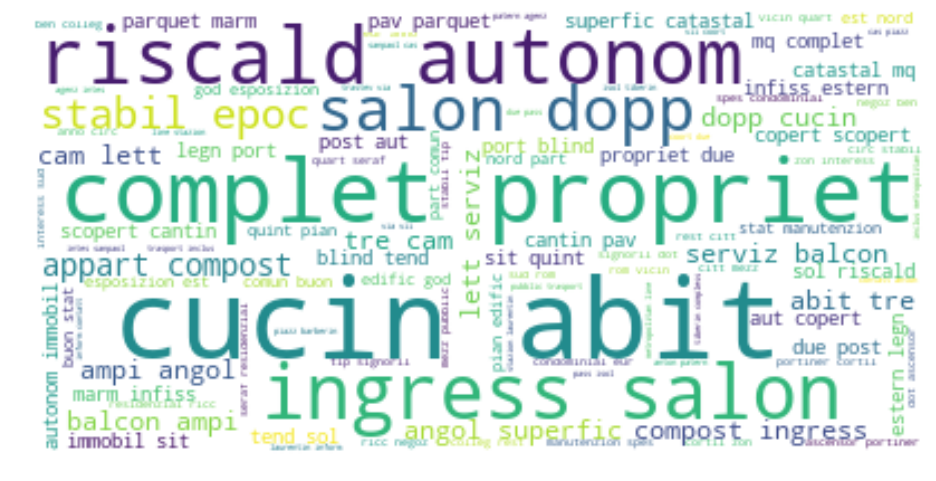

In [189]:
functions.generate_wordcloud(text = wordcloud_texts[0], name = "First_wordcloud")

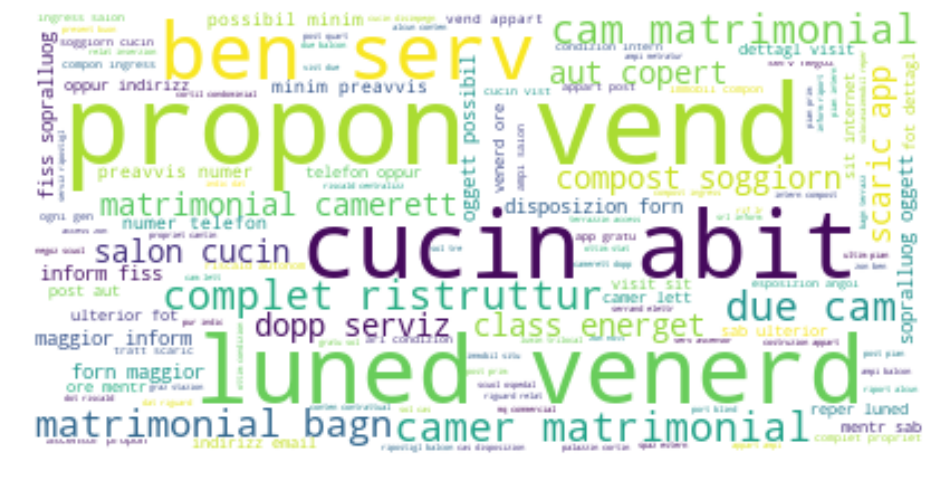

In [168]:
functions.generate_wordcloud(text = wordcloud_texts[1], name = "Second_wordcloud")

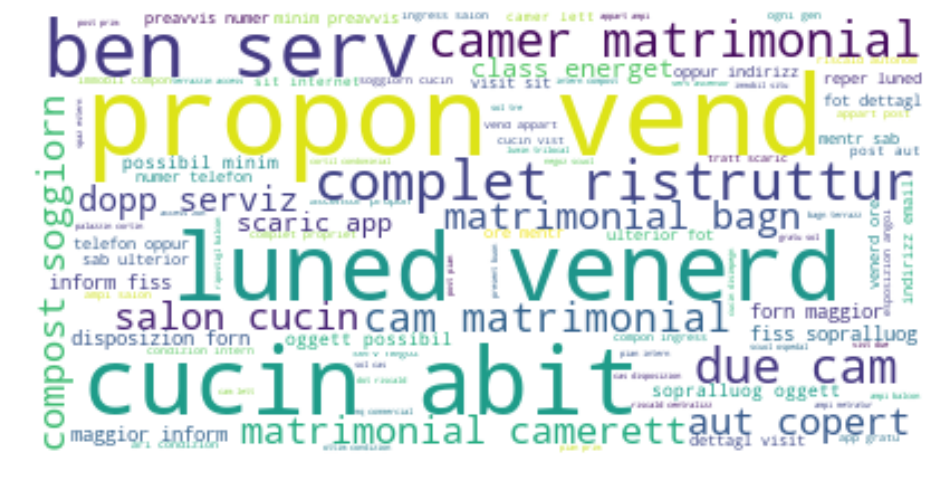

In [169]:
functions.generate_wordcloud(text = wordcloud_texts[2], name = "Third_wordcloud")